In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

In [58]:
import numpy as np
import pandas as pd
import signac
import os
import imageio
import glob
import itertools
from itertools import combinations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import CS_name_enum, Method_name_enum
from bo_methods_lib.bo_methods_lib.analyze_data import get_study_data_signac, get_best_data, open_file_helper, analyze_heat_maps
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import plot_heat_maps
from skimage.transform import resize

#Ignore warnings
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

#Set Stuff
date_time_str = None
meth_name_str_list = [1,2,3,4,5]
study_id = "ep"
log_data = False
save_csv = False
get_ei = False 
save_fig = True


#Set criteria dict
# criteria_dict = {"cs_name_val" : 2,
#                  "param_name_str" : "y0",
#                  "retrain_GP": 10,
#                  "num_x_data": 5,
#                  "outputscl": 1,
#                  "num_val_pts": 0,
#                  "sep_fact": 1.0,
#                  "ep_enum_val": 1,
#                  "lenscl": None}

criteria_dict = {"cs_name_val" : 1,
                 "param_name_str" : "t1t2",
                 "retrain_GP": 5,
                 "num_x_data": 5,
                 "outputscl": 1,
                 "num_val_pts": 20,
                 "sep_fact": 1.0,
                 "ep_enum_val": 1,
                 "lenscl": None}

#Set plot details
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
cmap = "autumn"

#Get project
project = signac.get_project()

#Get Best Data from ep experiment
df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
    df = pd.concat([df, df_piece], ignore_index=True)

df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, True)


#Get only the jobs which are the best
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

assert len(meth_name_str_list) == len(job_list_best), "lens not equal. Check Criteria dict"
#Make heat maps
#Get Best Data from ep experiment
df_best_path = job_list_best[0].fn("ep_study_best_all.csv")
df_best = pd.read_csv(df_best_path, header = 0, index_col = 0)

run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))
meth_names = list(df_best["BO Method"])

#Loop over best run/iter for each method
for i in range(len(job_list_best)):    
    run_num = run_num_list[i]
    bo_iter = bo_iter_list[i]
    file_path = job_list_best[i].fn("BO_Results.gz")
    string_val = df_best["Theta Min Obj"].iloc[0]
    numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    dim_theta = np.array(numbers).reshape(-1, 1)
    dim_theta = len(dim_theta)
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    method_name = Method_name_enum(meth_name_str_list[i]).name

    #Get Number of pairs
    pairs = len((list(combinations(dim_list, 2))))
    
    #Set the save path as the job path
    if save_fig == True:
        save_path = job_list_best[i].fn("")
        print(save_path)
    else:
        save_path = None

    #For each pair
    for pair in range(pairs):
        analysis_list = analyze_heat_maps(file_path, run_num, bo_iter, pair, log_data, get_ei)
        sim_sse_var_ei, test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, idcs_to_plot = analysis_list
        sse_sim, sse_mean, sse_var, ei = sim_sse_var_ei
        title = "Heat Map Pair " + "-".join(map(str, plot_axis_names))
        title = None
    #     z = [sse_sim, sse_mean, sse_var, ei]
    #     z_titles = ["ln(sse_sim)", "ln(sse)", "ln(sse_var)", "log(ei)"]
    #     levels = [100,100,100,100]
        z = [sse_sim, sse_mean, sse_var]
        z_titles = ["ln("+ r"$\mathbf{e(\theta)_{sim}}$" + ")", 
                    "ln("+ r"$\mathbf{e(\theta)_{gp}}$" + ")", 
                    "ln("+ r"$\mathbf{\sigma^2_{gp}}$" + ")"]
        z_save_names = ["sse_sim", "sse_gp_mean", "sse_var"]
        levels = [100,100,100]

        plot_heat_maps(test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, levels, idcs_to_plot, 
                    z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path, z_save_names)
        
    #Create mp4/gif files from pngs
    #Create directory to store Heat Map Movies
    dir_name = "Results/ep_study/" + name_cs_str + "/" + criteria_dict["param_name_str"] + "/" +  method_name + "/Heat_Maps/"
    print(dir_name)
    #Initialize filename list
    filenames = []
    
    #Add all Heat map data files to list
    for job in job_list_best:
        heat_map_files = glob.glob(job.fn("Heat_Maps/*/*.png"))
        filenames += heat_map_files
    if save_fig is True:
        if not os.path.isdir(dir_name):
            os.makedirs(dir_name)
        gif_path = dir_name + "param_combos.mp4"

        #Create .mp4 file
        with imageio.get_writer(gif_path, mode='I', fps=0.3) as writer: #Note. For gif use duration instead of fps
            #For each file
            for filename in filenames: 
                #Get image
                image = imageio.imread(filename, pilmode = "RGBA")
                #Get the correct shape for the pngs based on the 1st file
                if filename == filenames[0]: 
                    shape = image.shape
                    #Force image to have XY dims divisible by 16
                    new_shape = (np.ceil(shape[0] / 16) * 16, np.ceil(shape[1] / 16) * 16, shape[2])
                #If item shapes not the same force them to be the same. Fixes issues where pixels are off
                if image.shape is not shape: 
                    image = resize(image, (new_shape))
                #Add file to movie as a uint8 type and multiply array by 255 to get correct coloring
                writer.append_data((image*255).astype(np.uint8)) 

C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_16940\52265955.py:89: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_16940\52265955.py:89: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_16940\52265955.py:89: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_16940\52265955.py:89: FutureWarning: Calling in

fee9a9c27516a53fdb9e8ab98cdbb1ea
b0e257d6e76025909e364903b3b792ee
9806659b93e8e9181e26bad46843322c
485c5753f10c88a22e8ab45ebdeb87e3
ccbf60db414343459b615e183f31a62e
c:\Users\mcarlozo\Documents\Repos\Toy_Problem\workspace\fee9a9c27516a53fdb9e8ab98cdbb1ea\
Results/ep_study/CS1/t1t2/A1/Heat_Maps/
c:\Users\mcarlozo\Documents\Repos\Toy_Problem\workspace\b0e257d6e76025909e364903b3b792ee\
Results/ep_study/CS1/t1t2/B1/Heat_Maps/
c:\Users\mcarlozo\Documents\Repos\Toy_Problem\workspace\9806659b93e8e9181e26bad46843322c\
Results/ep_study/CS1/t1t2/A2/Heat_Maps/
c:\Users\mcarlozo\Documents\Repos\Toy_Problem\workspace\485c5753f10c88a22e8ab45ebdeb87e3\
Results/ep_study/CS1/t1t2/B2/Heat_Maps/
c:\Users\mcarlozo\Documents\Repos\Toy_Problem\workspace\ccbf60db414343459b615e183f31a62e\
Results/ep_study/CS1/t1t2/C2/Heat_Maps/


In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = False


criteria_dict = {"cs_name_val" : 2,
                 "param_name_str" : "y0",
                 "retrain_GP": 10,
                 "num_x_data": 5,
                 "outputscl":1,
                 "num_val_pts": 0,
                 "lenscl": None}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [3]:
### Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

# df_best["Min Obj Act"].iloc[2]
# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
35,13,1,112844.022531,1.0,0.0,"[-1.785522697428707, 1.513871650382233, 0.9561...",17561.613587,61431.907227,"[0.3420353008009523, -2.0, 0.0, 1.009136996573...",61431.907227,"[0.3420353008009523, -2.0, 0.0, 1.009136996573...",0.139521,1,A1,3,0.418563,2.935485
59,6,2,11.633762,1.0,0.0,"[0.3865958302752839, 0.059688701355287144, 1.9...",11.198131,11.699588,"[2.0, 0.39286802830510636, 1.7641983162349948,...",11.699588,"[2.0, 0.39286802830510636, 1.7641983162349948,...",0.410246,1,B1,3,1.230738,2.020228
599,11,57,37.120694,1.0,882.019718,"[-0.0026129174086711327, 0.4933121861468849, 1...",45.994886,35.677757,"[-0.0026153304293454753, 0.4933017201753367, 1...",35.677757,"[-0.0026153304293454753, 0.4933017201753367, 1...",1089.231827,1,A2,59,64264.677766,0.011525
730,0,19,11.633709,1.0,279.209008,"[-0.6274048388613718, -0.20070918286031647, 1....",10.874747,11.343344,"[-2.0, 0.6726516644401548, 1.470357839486535, ...",11.343344,"[-2.0, 0.6726516644401548, 1.470357839486535, ...",161.750979,1,B2,36,5823.035233,2.007983
1260,14,0,112844.022531,1.0,0.0,"[-0.5376238501428094, -1.5420921394617464, 1.2...",64541.902012,68006.282644,"[-1.1980190245432096, 0.47849715840638385, 1.9...",68006.282644,"[-1.1980190245432096, 0.47849715840638385, 1.9...",42.811267,1,C2,4,171.245068,1.285848


In [4]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

cd9fca2cc0e685bedb310073cf3d06eb
2cae46307674e66d32bbd97dc188afa1
93eb2fe14ef5ef207a7fbe09d99bd547
5521c16d631ba3c8ba047c351a77465d
8adf6602de7e3e082e87da1066e992f2


C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_15644\749023213.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_15644\749023213.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_15644\749023213.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_15644\749023213.py:13: FutureWarning: Callin

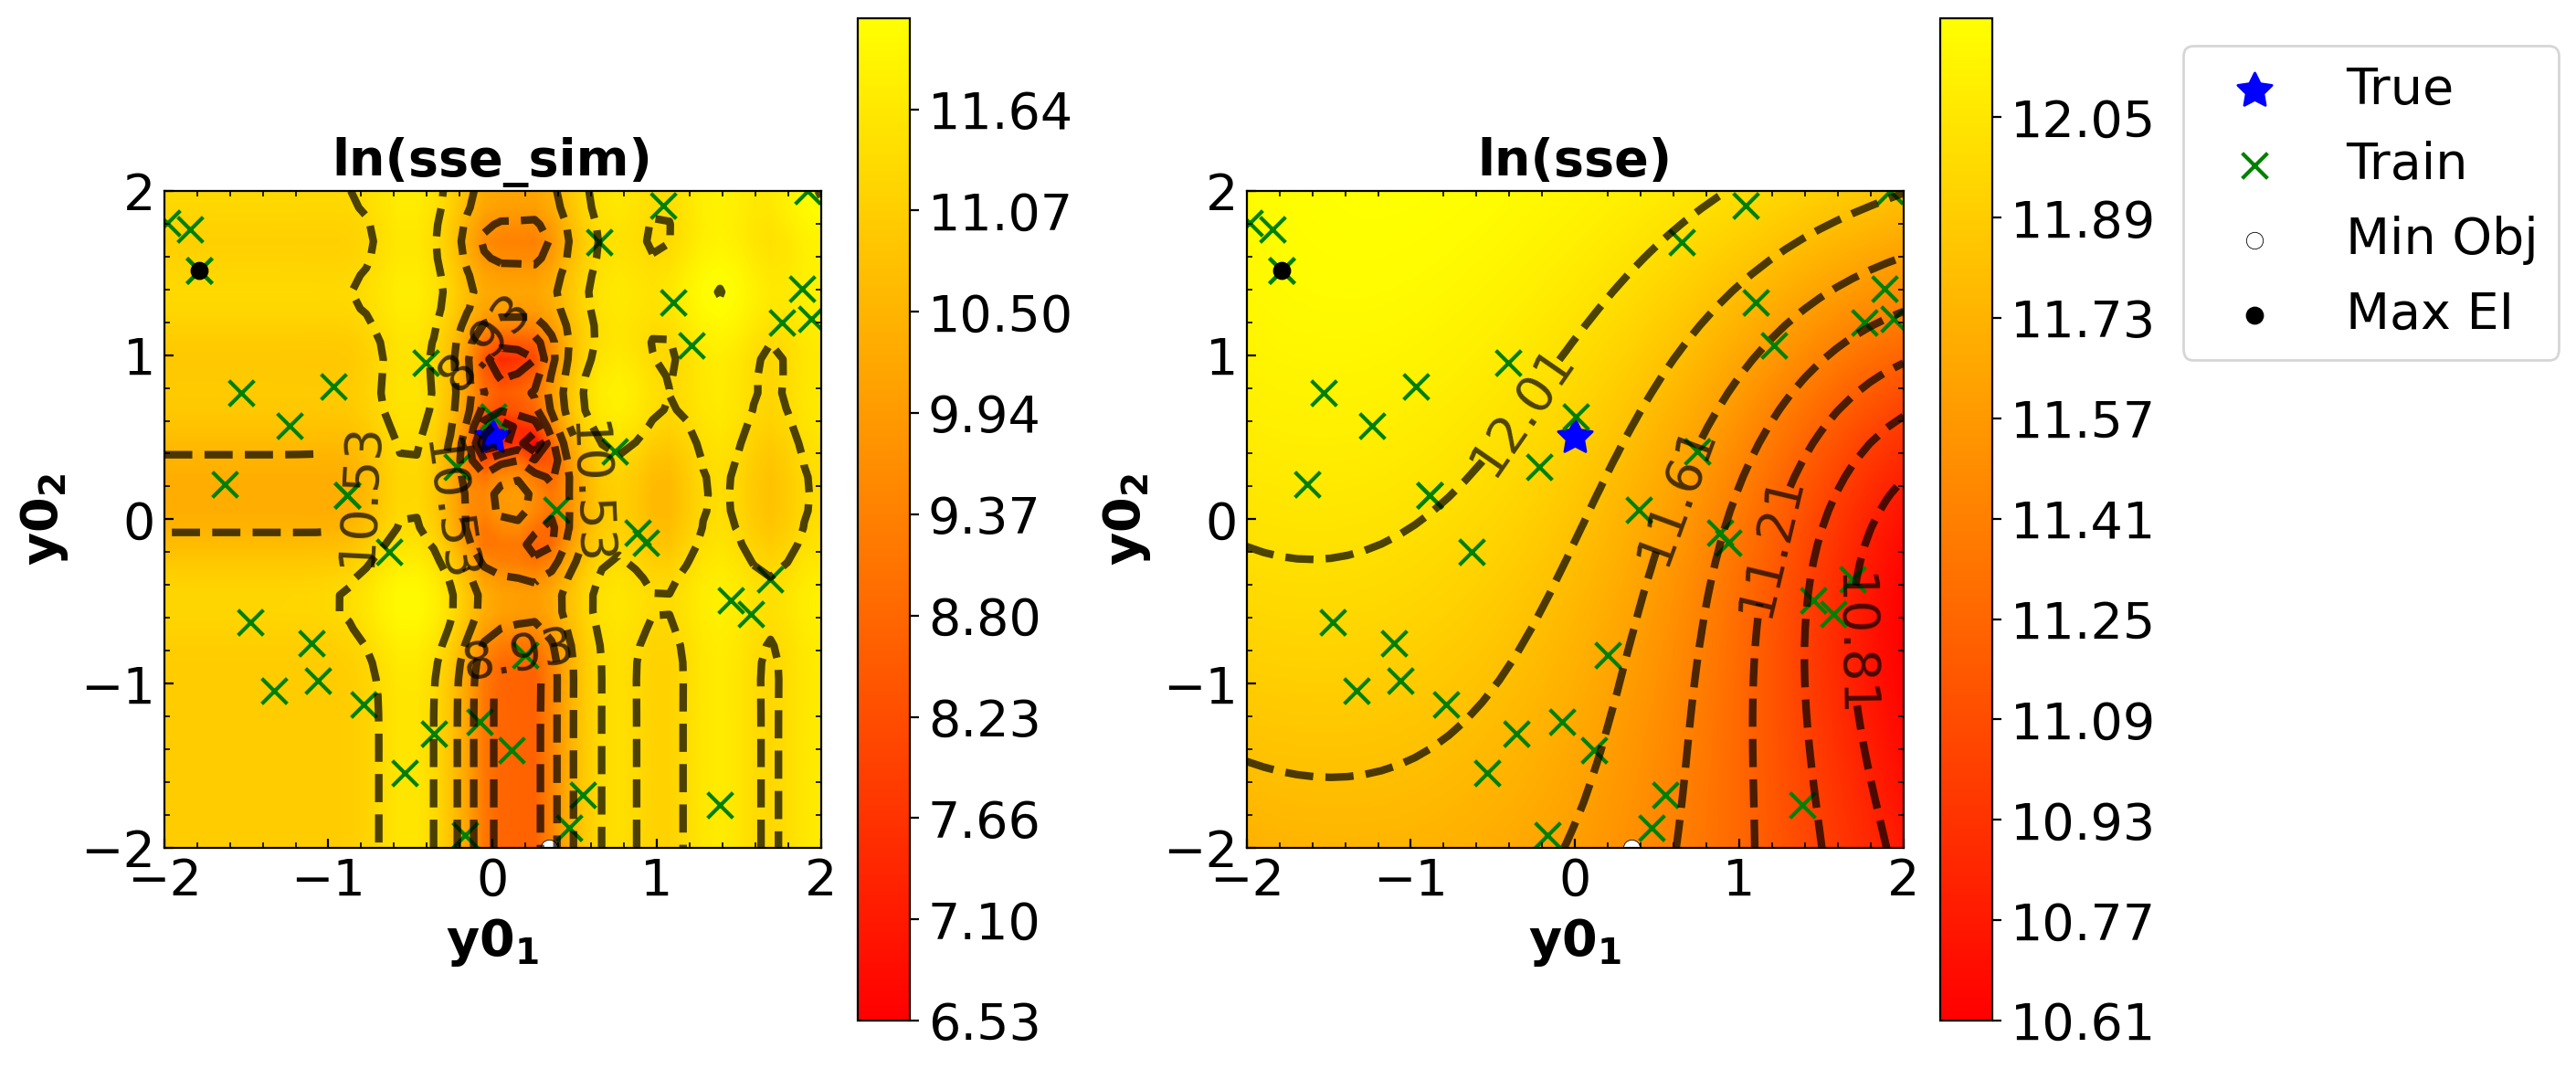

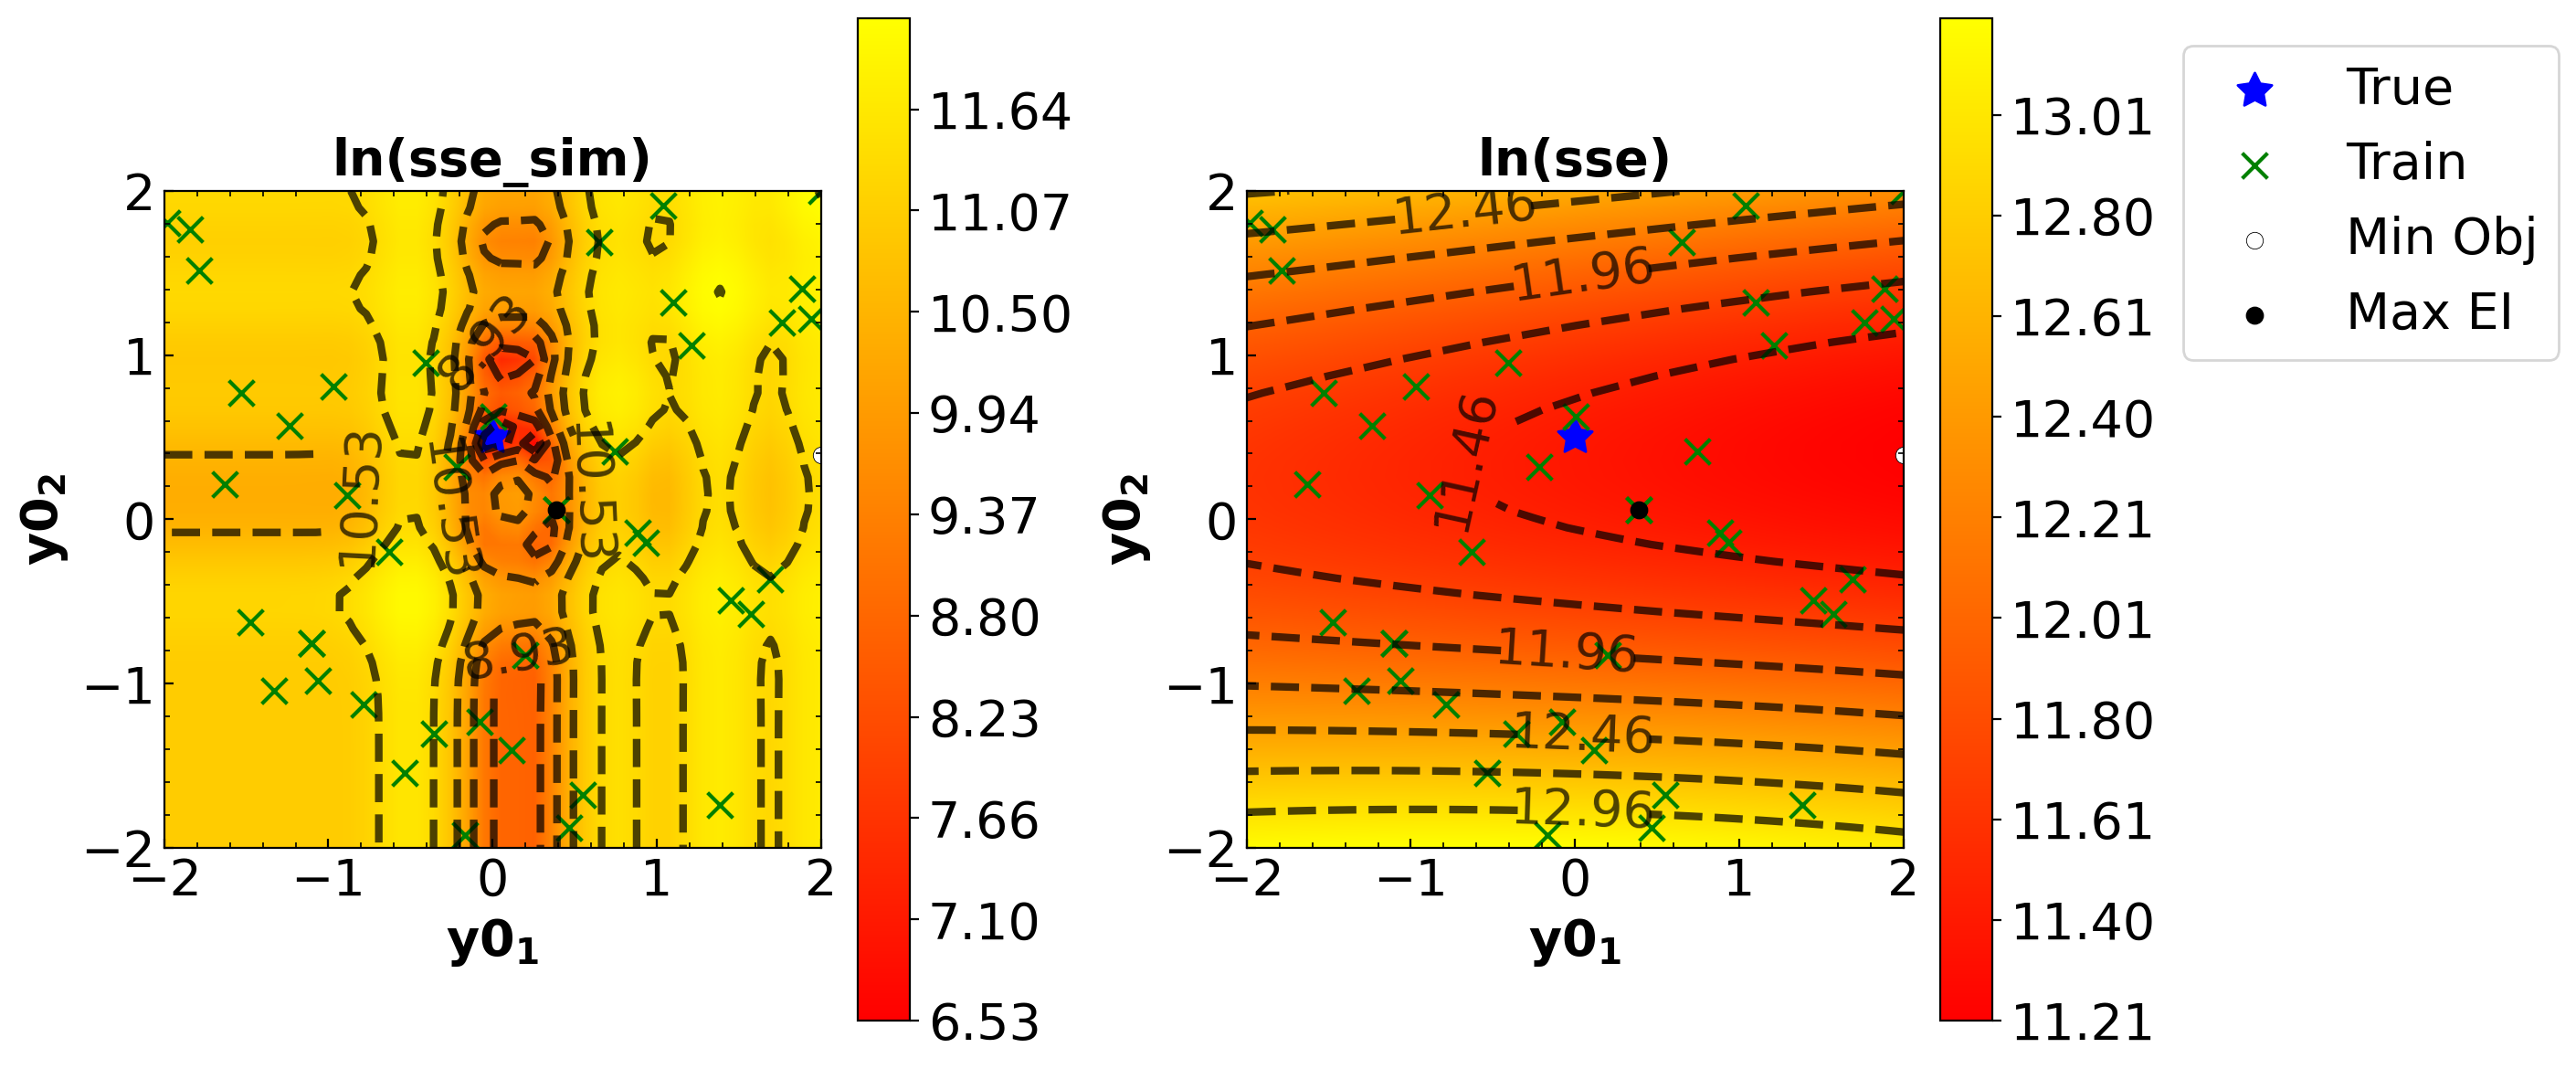

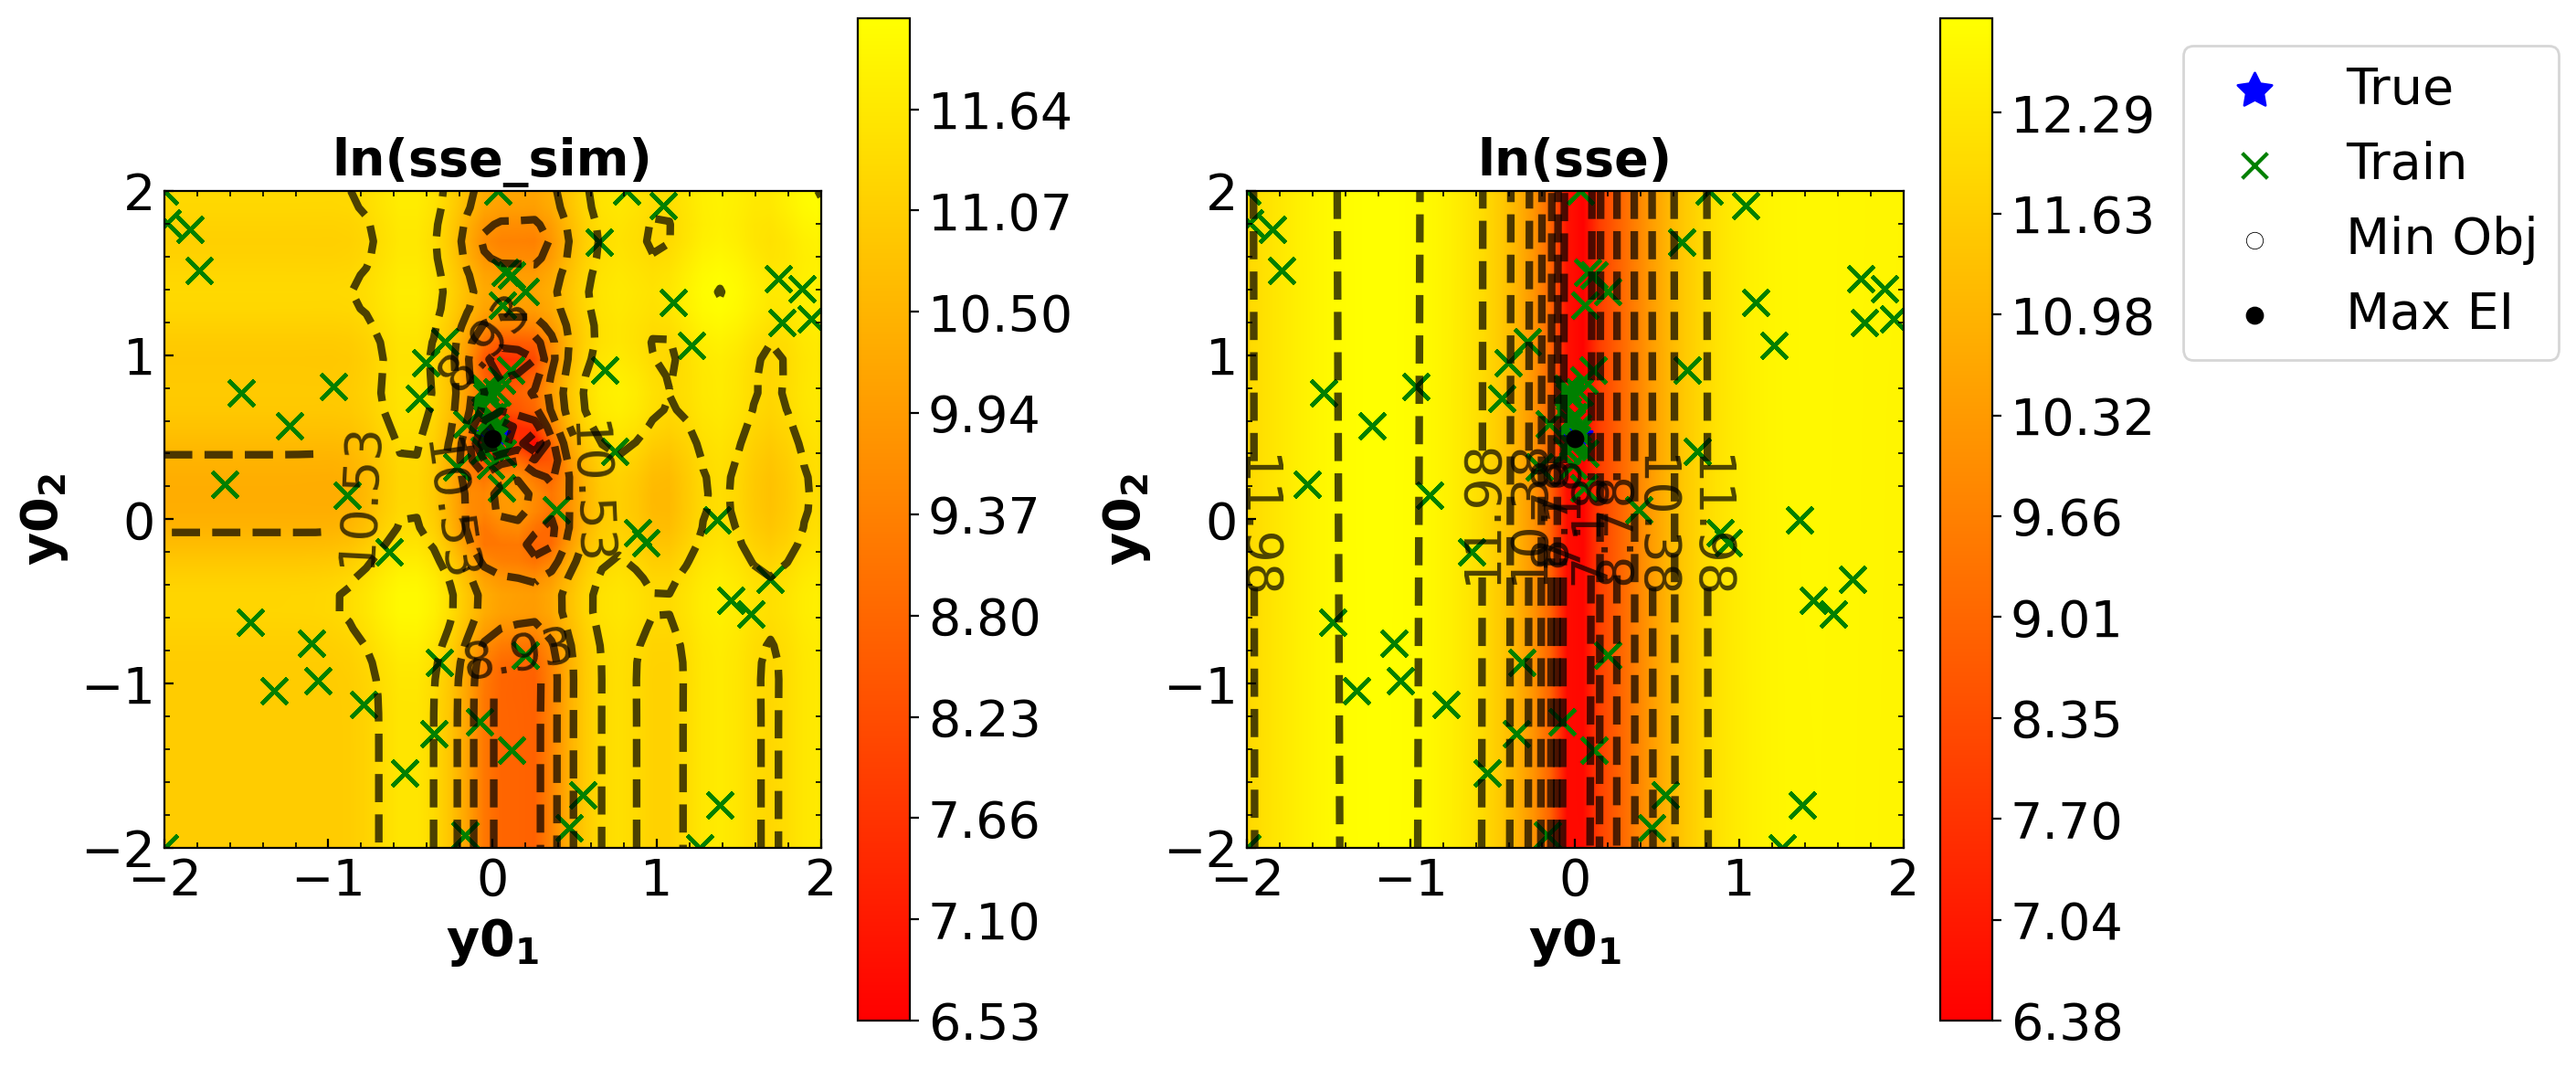

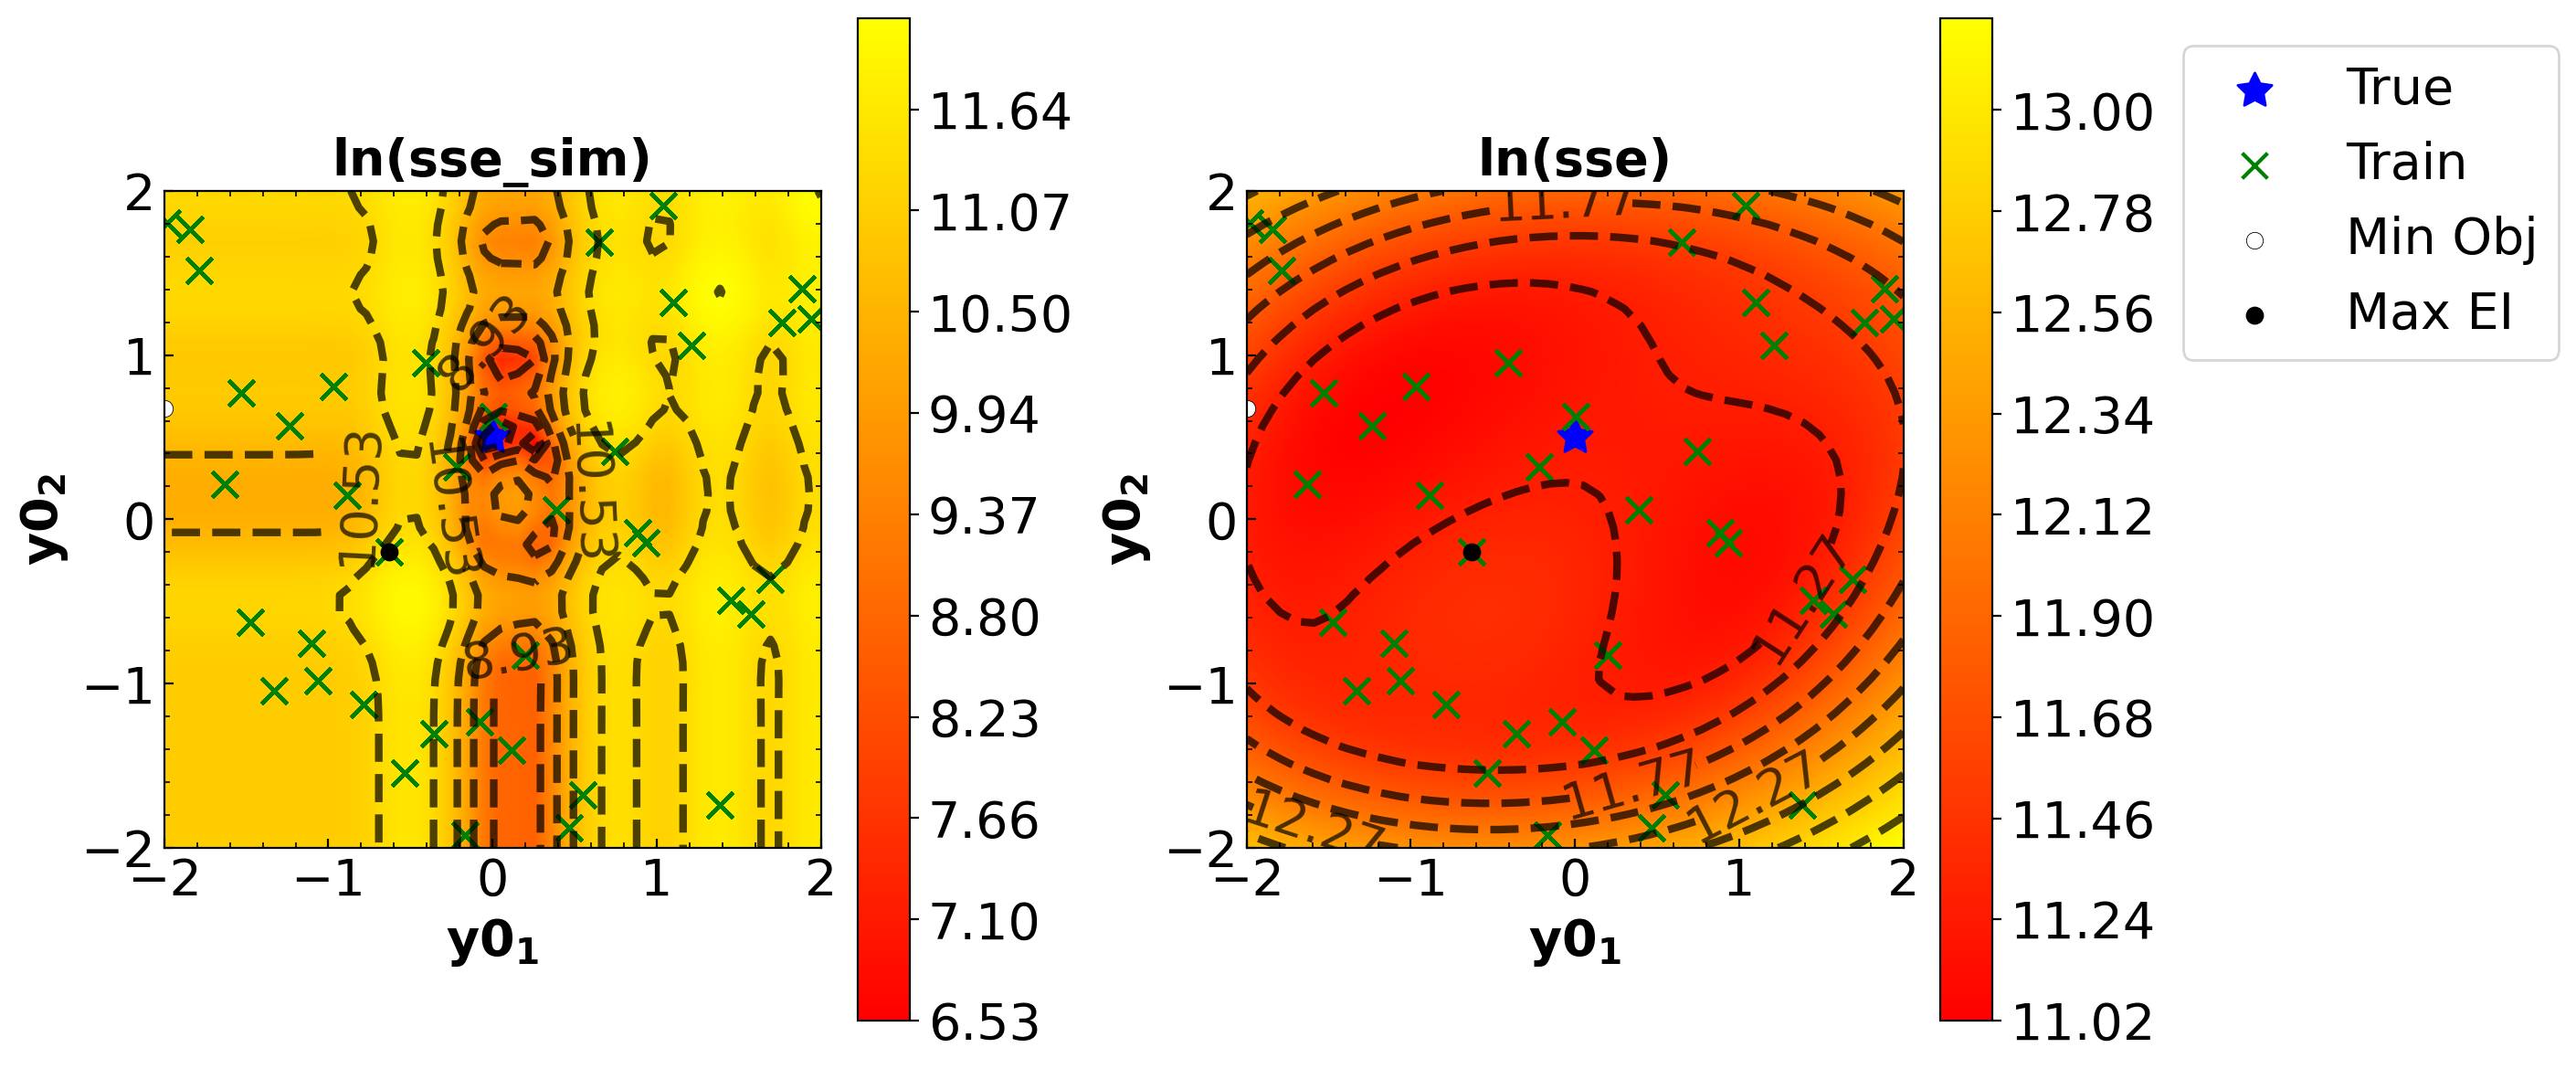

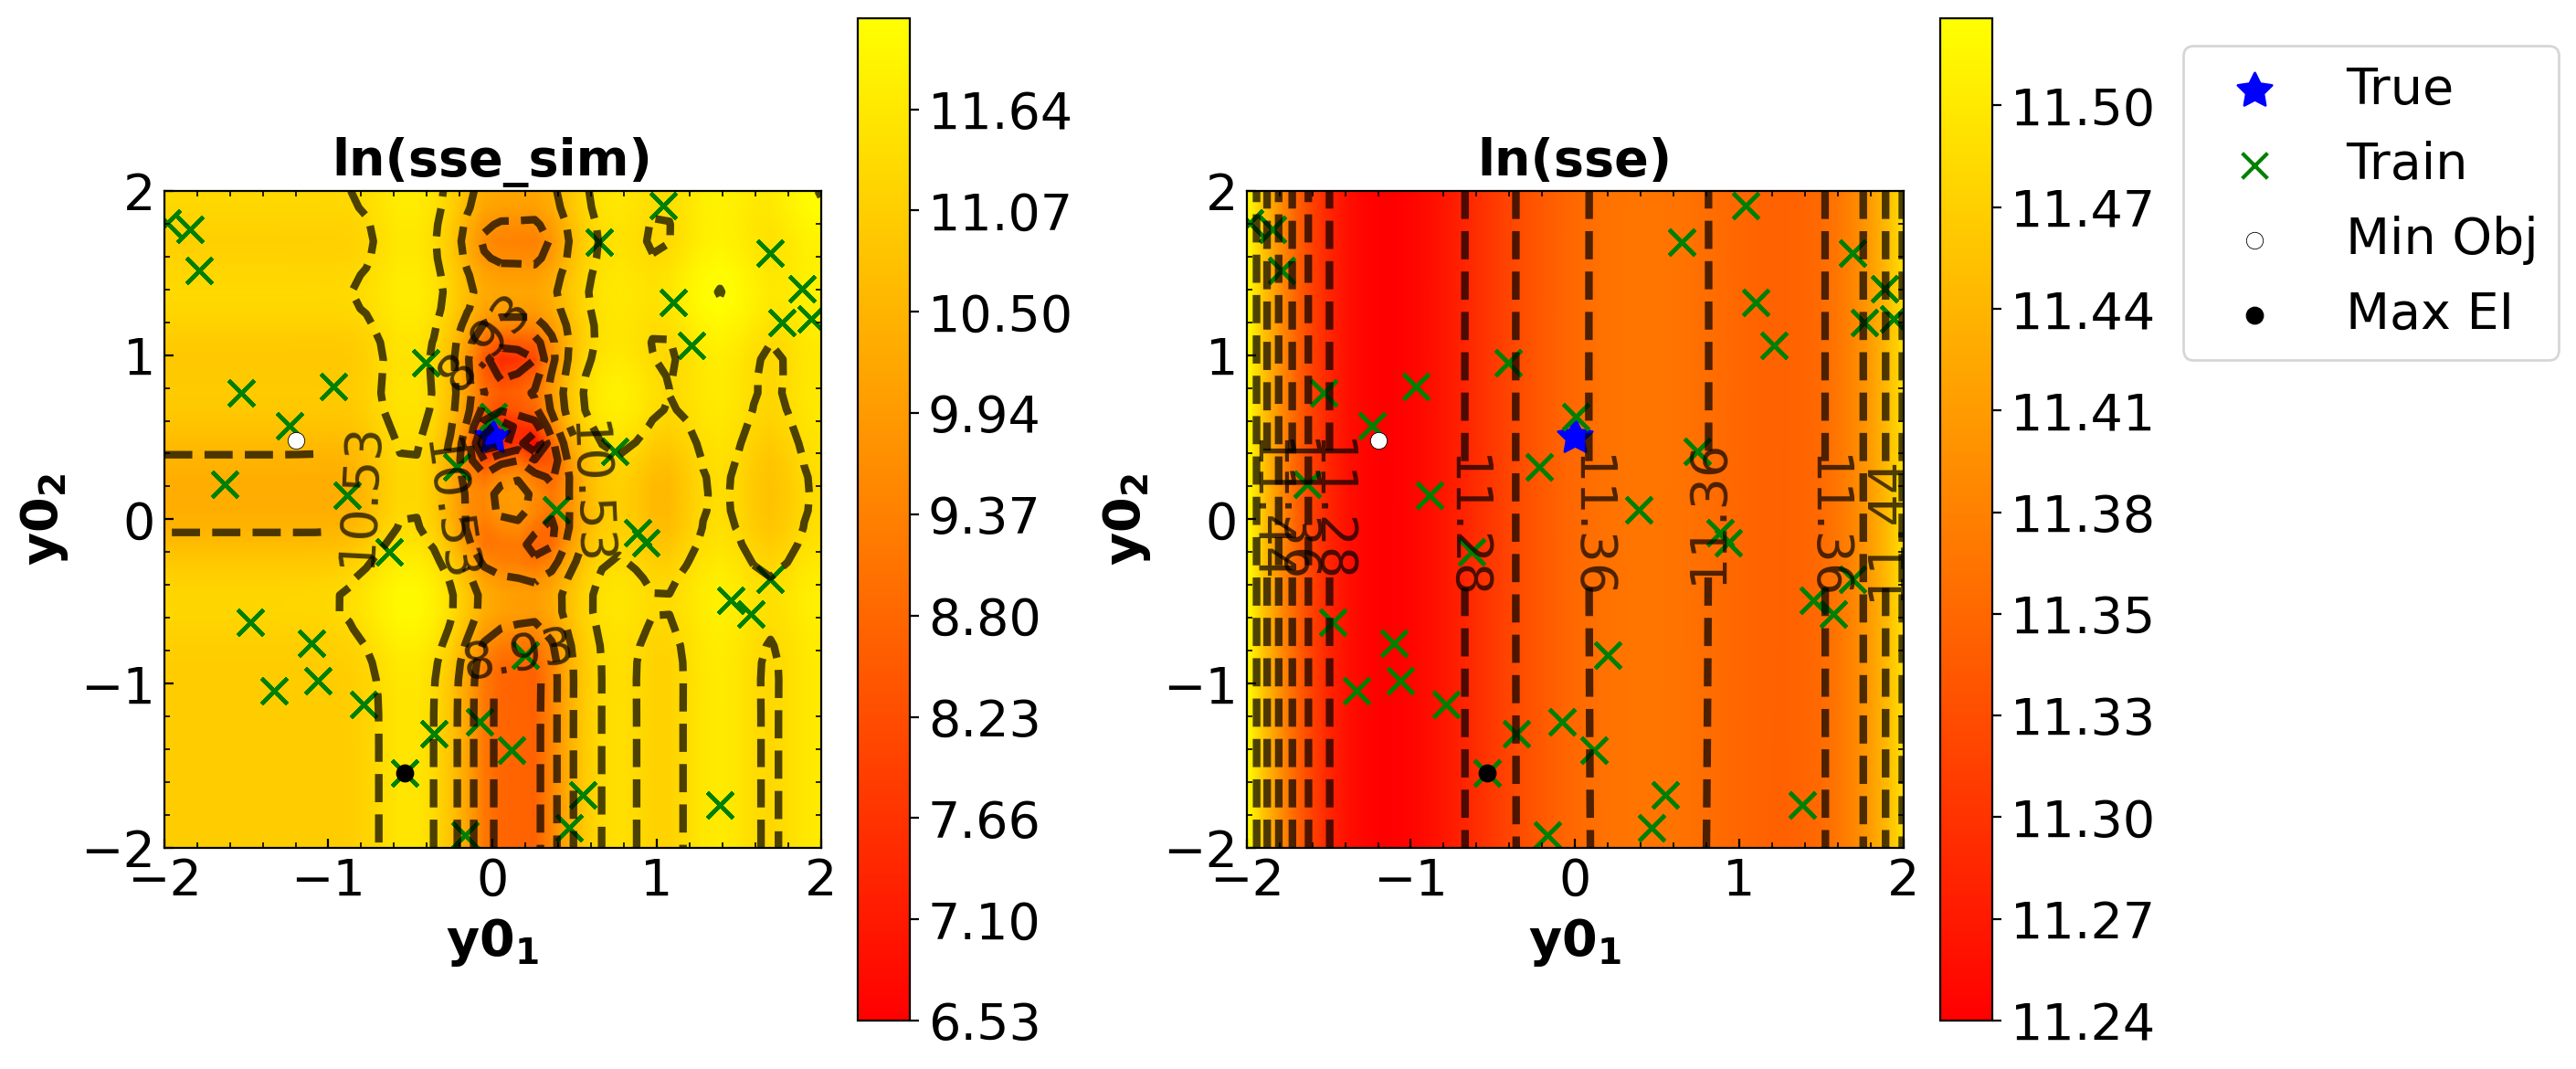

In [5]:
#Make heat maps
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_fig = False
cmap = "autumn"
log_data = True

#Get Best Data from ep experiment
df_best_path = job_list_best[0].fn("ep_study_best_all.csv")
df_best = pd.read_csv(df_best_path, header = 0, index_col = 0)

run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))
meth_names = list(df_best["BO Method"])

for i in range(len(job_list_best)):    
    run_num = run_num_list[i]
    bo_iter = bo_iter_list[i]
    file_path = job_list_best[i].fn("BO_Results.gz")
    string_val = df_best["Theta Min Obj"].iloc[0]
    numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    dim_theta = np.array(numbers).reshape(-1, 1)
    dim_theta = len(dim_theta)
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    pair = 0
    
    get_ei = False
    analysis_list = analyze_heat_maps(file_path, run_num, bo_iter, pair, log_data, get_ei)
    sim_sse_var_ei, test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, idcs_to_plot = analysis_list
    sse_sim, sse_mean, sse_var, ei = sim_sse_var_ei

    title = "Heat Map Pair " + "-".join(map(str, plot_axis_names))
    title = None
#     z = [sse_sim, sse_mean, sse_var, ei]
#     z_titles = ["ln(sse_sim)", "ln(sse)", "ln(sse_var)", "log(ei)"]
#     levels = [100,100,100, 100]
    z = [sse_sim, sse_mean]
    z_titles = ["ln(sse_sim)", "ln(sse)"]
    levels = [100,100]
#     z = [sse_mean]
#     z_titles = [meth_names[i] + " log("+ r"$\mathbf{e(\theta)}$" + ")"]
    
    
    save_path = job_list[i].fn("")
    
    if save_fig == False:
        save_path = None

    plot_heat_maps(test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, levels, idcs_to_plot, 
                   z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)